# Business Statement

- Problem solved
    - Classification algorithm to identify fraud bank account applications


In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
import random
import math
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import time
import warnings
warnings.filterwarnings('ignore')

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_recall_curve

# fig, ax = plt.subplots(figsize = (20, 10))

In [2]:
baf_base = pd.read_csv('../Data/Base.csv')

In [3]:
# Look at the proportion of fraud vs non-fraud labels

baf_base['fraud_bool'].value_counts()/len(baf_base)*100

0    98.8971
1     1.1029
Name: fraud_bool, dtype: float64

In [4]:
baf_base.describe().apply(lambda x: x.apply('{0:.5f}'.format))

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,zip_count_4w,velocity_6h,...,phone_mobile_valid,bank_months_count,has_other_cards,proposed_credit_limit,foreign_request,session_length_in_minutes,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
count,1000000.00000,1000000.00000,1000000.00000,1000000.00000,1000000.00000,1000000.00000,1000000.00000,1000000.00000,1000000.00000,1000000.00000,...,1000000.00000,1000000.00000,1000000.00000,1000000.00000,1000000.00000,1000000.00000,1000000.00000,1000000.00000,1000000.00000,1000000.00000
mean,0.01103,0.56270,0.49369,16.71857,86.58787,33.68908,1.02571,8.66150,1572.69205,5665.29660,...,0.88968,10.83930,0.22299,515.85101,0.02524,7.54494,0.57695,1.01831,0.00000,3.28867
std,0.10444,0.29034,0.28912,44.04623,88.40660,12.02580,5.38183,20.23615,1005.37456,3009.38067,...,0.31329,12.11687,0.41625,487.55990,0.15686,8.03311,0.49404,0.18076,0.00000,2.20999
min,0.00000,0.10000,0.00000,-1.00000,-1.00000,10.00000,0.00000,-15.53055,1.00000,-170.60307,...,0.00000,-1.00000,0.00000,190.00000,0.00000,-1.00000,0.00000,-1.00000,0.00000,0.00000
25%,0.00000,0.30000,0.22522,-1.00000,19.00000,20.00000,0.00719,-1.18149,894.00000,3436.36585,...,1.00000,-1.00000,0.00000,200.00000,0.00000,3.10305,0.00000,1.00000,0.00000,1.00000
50%,0.00000,0.60000,0.49215,-1.00000,52.00000,30.00000,0.01518,-0.83051,1263.00000,5319.76935,...,1.00000,5.00000,0.00000,200.00000,0.00000,5.11432,1.00000,1.00000,0.00000,3.00000
75%,0.00000,0.80000,0.75557,12.00000,130.00000,40.00000,0.02633,4.98418,1944.00000,7680.71783,...,1.00000,25.00000,0.00000,500.00000,0.00000,8.86613,1.00000,1.00000,0.00000,5.00000
max,1.00000,0.90000,1.00000,383.00000,428.00000,90.00000,78.45690,112.95693,6700.00000,16715.56540,...,1.00000,32.00000,1.00000,2100.00000,1.00000,85.89914,1.00000,2.00000,0.00000,7.00000


# Choosing Some Variables For Univariate Analysis

- Income
- Intended Balcon Amount
- Credit Risk Score
- Proposed Credit Limit
- Session Length in Minutes

In [5]:
# Function to plot histogram + boxplot

def visualize_distribution(feature):
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 5))

    sns.histplot(baf_base[feature], kde = True, ax = ax1)
    sns.boxplot(baf_base[feature], ax = ax2)

    ax1.set_xlabel(feature)
    ax1.set_title('Histogram Plotted for {}'.format(feature))
    
    ax2.set_xlabel(feature)
    ax2.set_title('Boxplot Plotted for {}'.format(feature))
    plt.show()

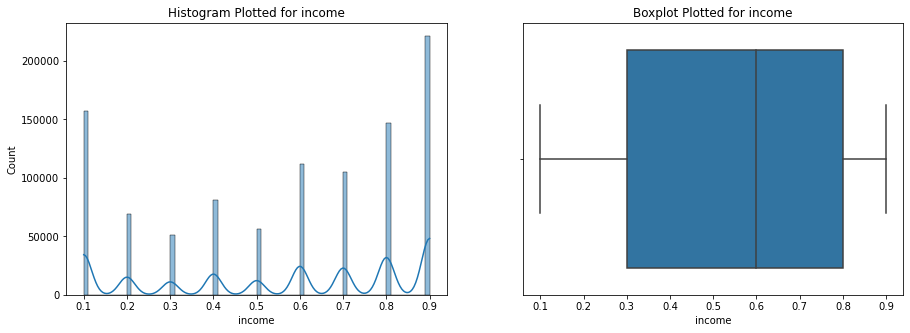

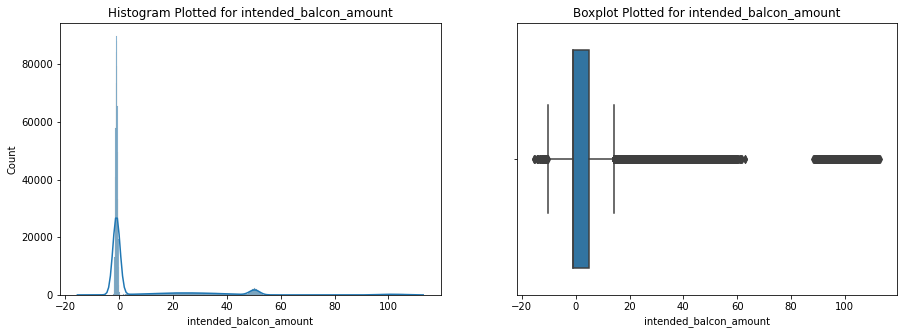

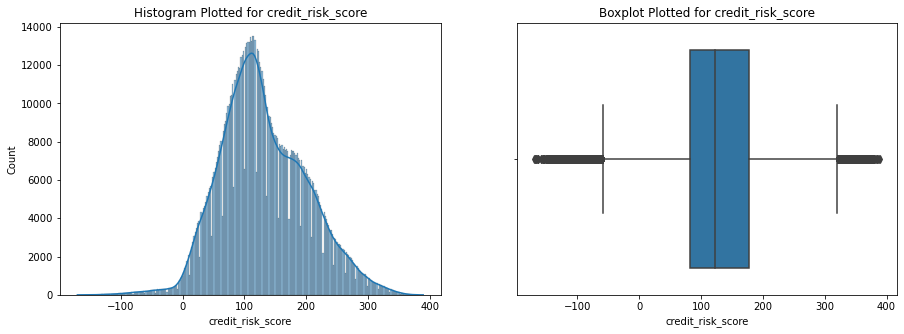

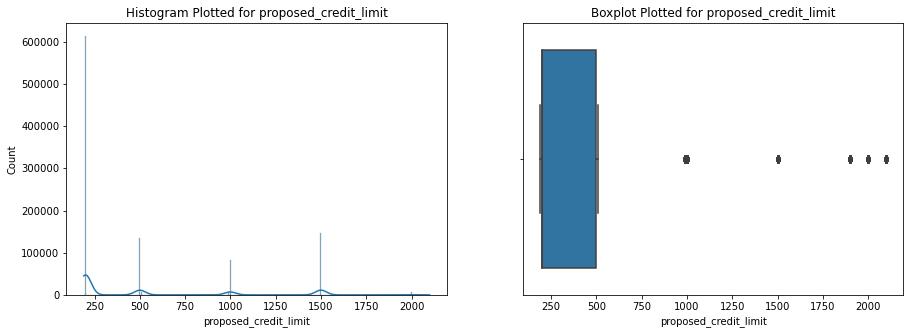

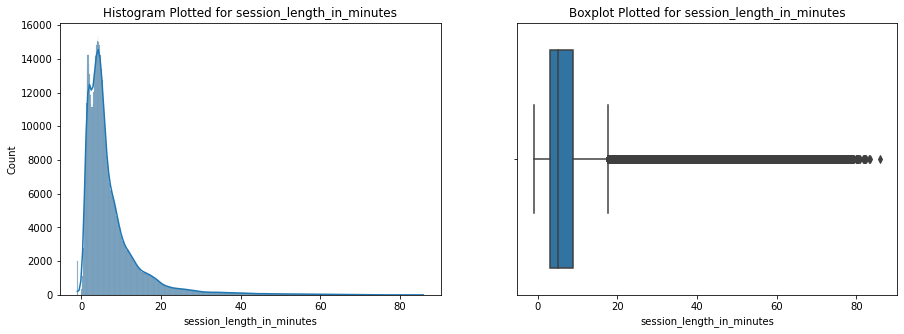

In [6]:
features_lst = ['income', 'intended_balcon_amount', 'credit_risk_score', 'proposed_credit_limit', 'session_length_in_minutes']

for feature in features_lst:
    
    visualize_distribution(feature)

# Observations:

- Intended Balcon Amount (which is the initial transfer amount for the application) and session length in minutes has extremely long tails, proceed to check outliers
- Credit Risk Score close to Gaussian distribution
- Handful of high credit limit proposed, potential correlation with target?
- We need to see if these distributions remain the same after SMOTE

# Correlations with Target 

- Use SMOTE to fix imbalance & make correlations between features more obvious

In [7]:
# Ignore categorical variables for now
y_corr = baf_base['fraud_bool']
X_corr = baf_base.drop('fraud_bool', axis = 1).select_dtypes('number')

smo = SMOTE()

X_corr_smo, y_corr_smo = smo.fit_resample(X_corr, y_corr)

<AxesSubplot:>

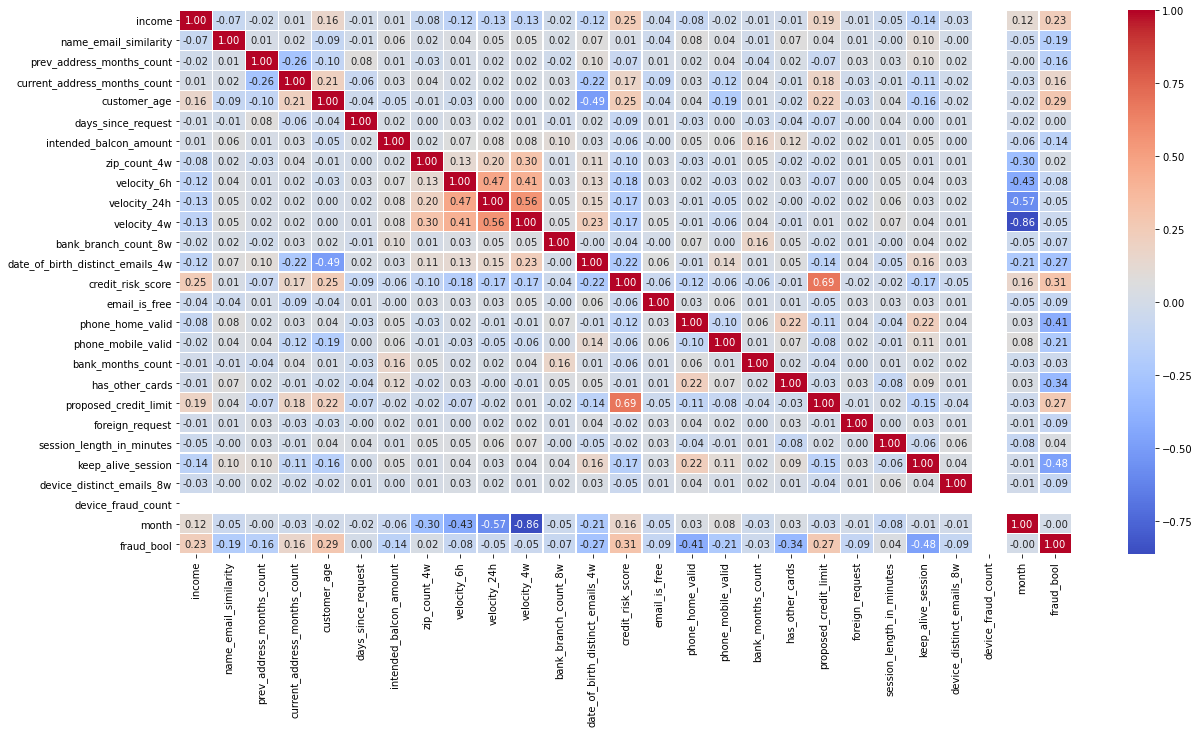

In [8]:
smote_corr = pd.concat([X_corr_smo, y_corr_smo], axis = 1).corr()

fig, ax = plt.subplots(figsize = (20, 10))

sns.heatmap(smote_corr, cmap='coolwarm', annot=True, fmt=".2f", linewidths=.5)

# Observations:

- Strong correlation between credit risk score & proposed credit limit
- Correlation between income & credit risk score 
- Velocity features are correlated
- Several features with strong correlations to the target

# Feature Selection

- We start with features that has some correlation to the target & also make logical sense to us

In [9]:
target_corr = smote_corr['fraud_bool']
target_corr[abs(target_corr) > 0.2]

income                              0.234810
customer_age                        0.286866
date_of_birth_distinct_emails_4w   -0.269039
credit_risk_score                   0.305412
phone_home_valid                   -0.407733
phone_mobile_valid                 -0.209517
has_other_cards                    -0.336376
proposed_credit_limit               0.267354
keep_alive_session                 -0.475573
fraud_bool                          1.000000
Name: fraud_bool, dtype: float64

In [10]:
#Select most of these for first pass in the model
selected_features = ['income', 'customer_age', 'date_of_birth_distinct_emails_4w',
                     'credit_risk_score', 'phone_home_valid', 'has_other_cards', 'proposed_credit_limit',
                    'keep_alive_session']

In [11]:
# This is a binary variable
baf_base['phone_home_valid'].value_counts()

# Lets look at all the binary variables
binary_cols = baf_base[selected_features].loc[:,baf_base[selected_features].isin([0,1]).all()]
binary_cols.head()

,phone_home_valid,has_other_cards,keep_alive_session
0,1,0,0
1,0,0,0
2,0,0,0
3,0,1,0
4,1,0,1


# Processing Outliers

In [12]:
def histogram_scatterplot(feature):
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 5))
    
    sns.histplot(baf_base[feature], kde = True, ax = ax1)
    sns.scatterplot(x = baf_base[feature], y = baf_base['fraud_bool'], ax = ax2)

    ax1.set_xlabel(feature)
    ax1.set_title('Histogram Plotted for {}'.format(feature))
    
    ax2.set_xlabel(feature)
    ax2.set_title('Scatterplot Plotted for {}'.format(feature))
    plt.show()

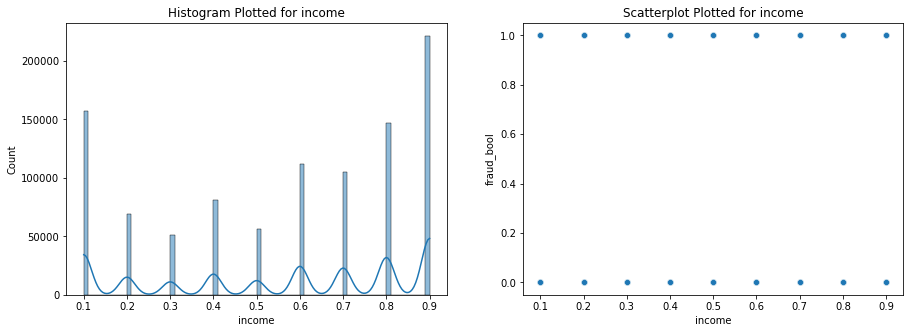

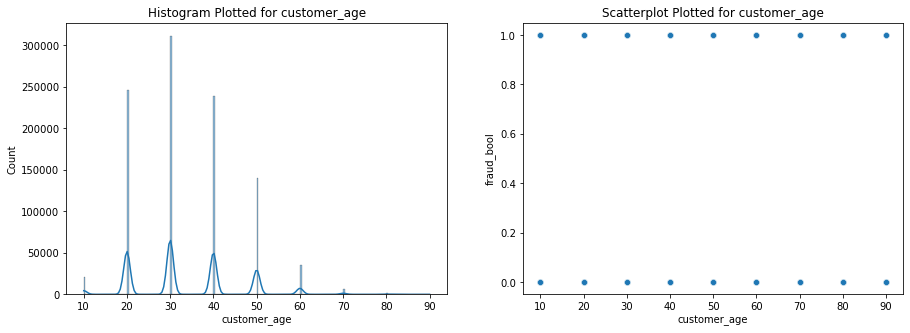

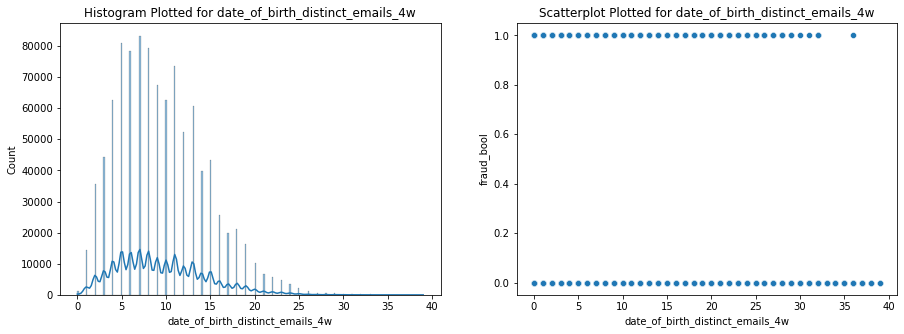

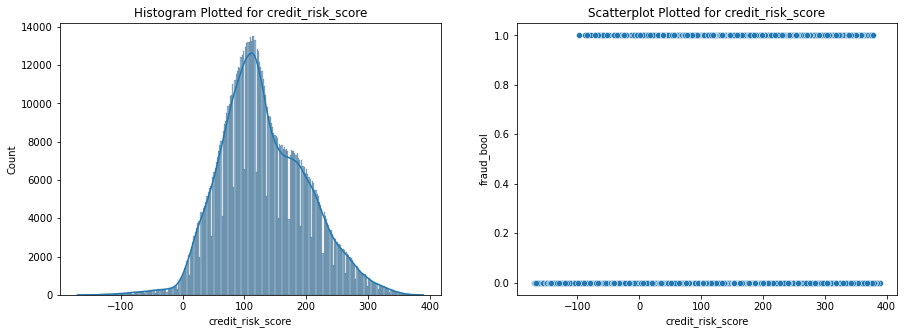

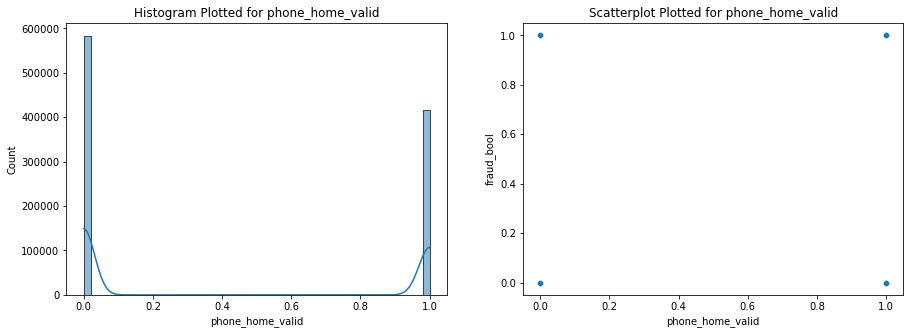

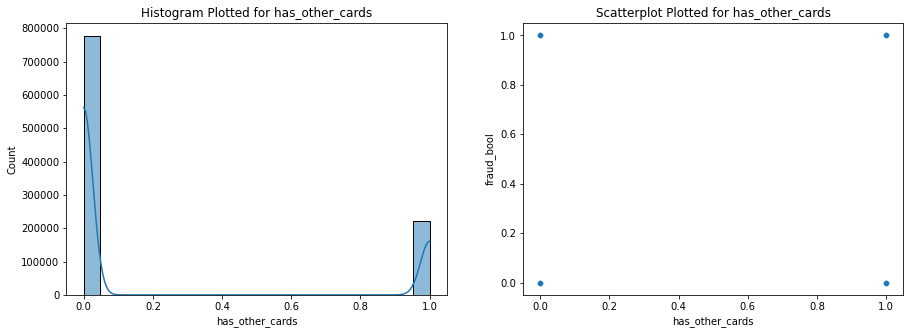

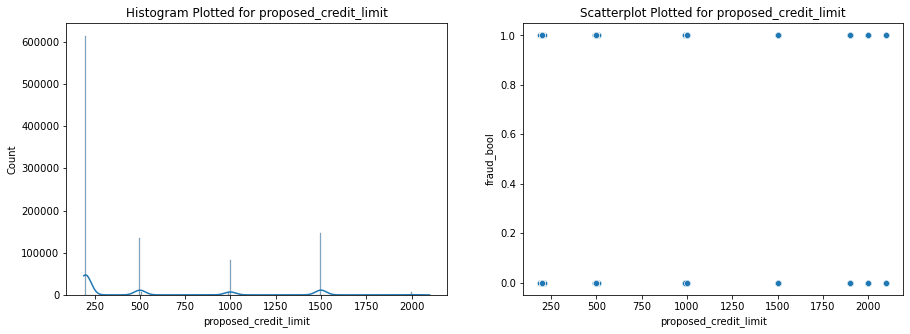

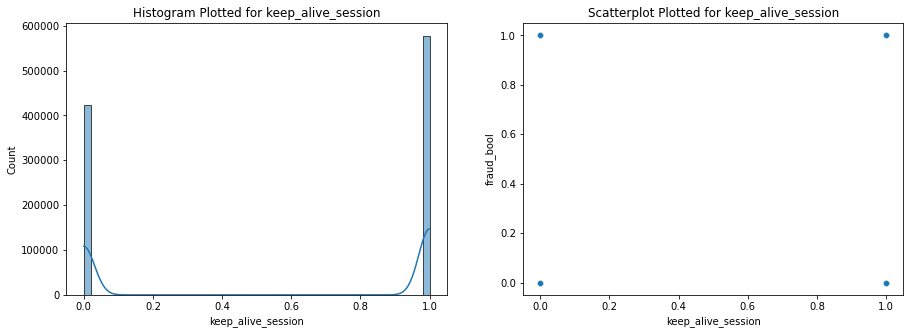

In [13]:
for feature in selected_features:
    histogram_scatterplot(feature)

# Train Test Split

In [14]:
# Define independent & dependent variables (drop binary features for now, add back the ones we want later)
y = baf_base['fraud_bool']
# X = baf_base[selected_features]

# Binary distributions are changed by SMOTE (see below), substitute
X = baf_base[selected_features].drop(binary_cols.columns, axis = 1)


# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify = y, random_state = 42)

# Applying SMOTE to Address Target Imbalance, Then Standardize

In [15]:
#SMOTE to fix imbalance
smo = SMOTE()

X_train_smo, y_train_smo = smo.fit_resample(X_train, y_train)
print(y_train_smo.value_counts())

# Select only numerical features  
X_train_num = X_train_smo.select_dtypes('number')#.drop(binary_cols.columns, axis = 1)
X_test_num = X_test.select_dtypes('number')#.drop(binary_cols.columns, axis = 1)

# # Select only categorical features 
# X_train_cat = X_train.select_dtypes('object')
# X_test_cat = X_test.select_dtypes('object')

# Standardize numeric independent variables
scaler = MinMaxScaler()

X_train_std = pd.DataFrame(scaler.fit_transform(X_train_num), columns = X_train_num.columns, index = X_train_num.index)
X_test_std = pd.DataFrame(scaler.transform(X_test_num), columns = X_test_num.columns, index = X_test_num.index)

# # One hot encode the categorical variables

# X_train_cat_std = pd.get_dummies(X_train_cat, drop_first = True)
# X_test_cat_std = pd.get_dummies(X_test_cat, drop_first = True)

# # Concat the standardized numerical and one-hot encoded categorical variables

# X_train = pd.concat([X_train_std, X_train_cat_std], axis = 1)
# X_test = pd.concat([X_test_std, X_test_cat_std], axis = 1)

# Add back in the binary features
# X_train_processed = pd.concat([X_train_std, X_train_smo[binary_cols.columns]], axis = 1)
# X_test_processed = pd.concat([X_test_std, X_test[binary_cols.columns]], axis = 1)

X_train_processed = X_train_std.copy()
X_test_processed = X_test_std.copy()

1    692280
0    692280
Name: fraud_bool, dtype: int64


# Check Variable Distributions After SMOTE & Standardizing

In [16]:
# Check to see
X_train_processed.head()
# Look at histogram X_train vs X_test

,income,customer_age,date_of_birth_distinct_emails_4w,credit_risk_score,proposed_credit_limit
0,1.000,0.375,0.076923,0.676208,0.005236
1,1.000,0.375,0.384615,0.475850,0.005236
2,0.125,0.250,0.153846,0.618962,0.162304
3,1.000,0.125,0.282051,0.536673,0.005236
4,0.625,0.125,0.179487,0.320215,0.005236


<AxesSubplot:xlabel='credit_risk_score', ylabel='Count'>

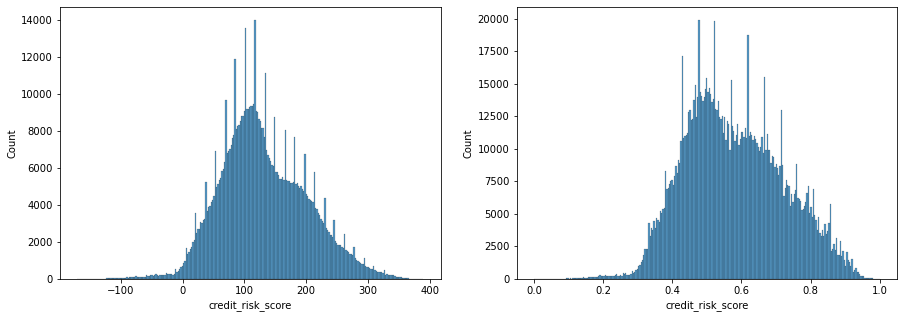

In [17]:
# Check to see that the distribution are the same after standardizing
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 5))

# Before SMOTE & Standardizing
sns.histplot(X_train['credit_risk_score'], ax = ax1)
# After SMOTE & Standardizing
sns.histplot(X_train_processed['credit_risk_score'], ax = ax2)

<AxesSubplot:xlabel='proposed_credit_limit', ylabel='Count'>

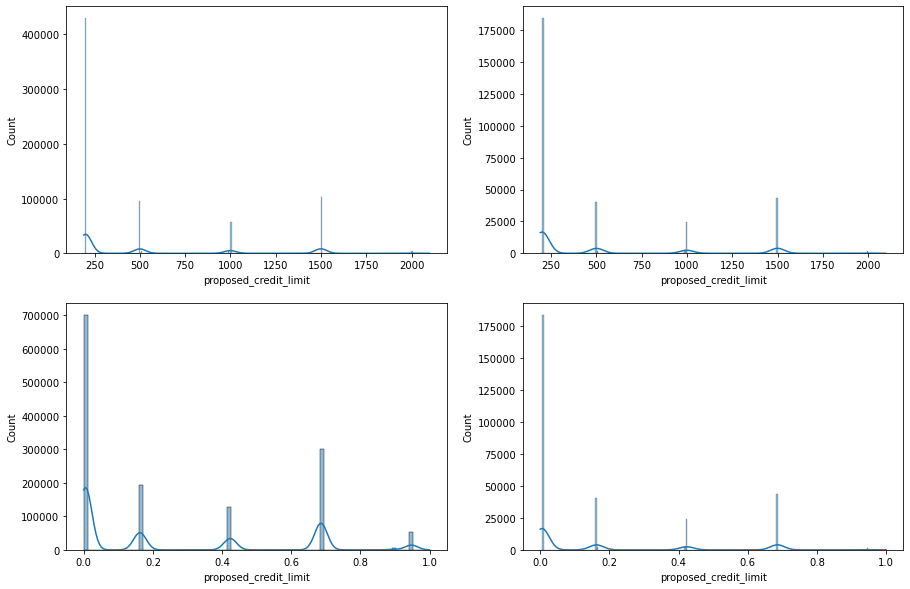

In [18]:
# Check to see that the distribution are the same between X_train, X_test before & after SMOTE + standardization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (15, 10))

sns.histplot(X_train['proposed_credit_limit'], kde = True, ax = ax1)
sns.histplot(X_test['proposed_credit_limit'], kde = True, ax = ax2)

sns.histplot(X_train_processed['proposed_credit_limit'], kde = True, ax = ax3)
sns.histplot(X_test_processed['proposed_credit_limit'], kde = True, ax = ax4)

<AxesSubplot:xlabel='income', ylabel='Count'>

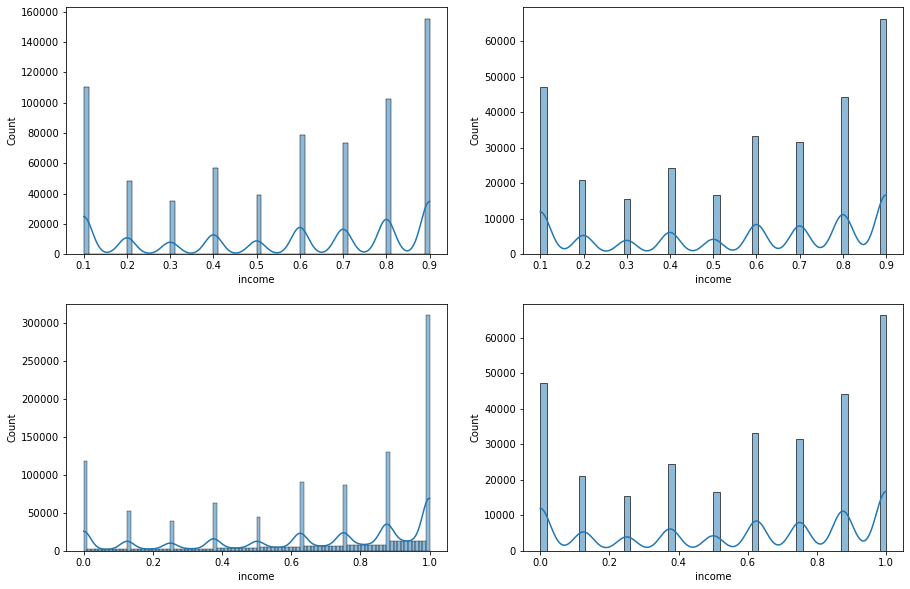

In [19]:
# Check to see that the distribution are the same between X_train, X_test before & after SMOTE + standardization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (15, 10))

sns.histplot(X_train['income'], kde = True, ax = ax1)
sns.histplot(X_test['income'], kde = True, ax = ax2)

sns.histplot(X_train_processed['income'], kde = True, ax = ax3)
sns.histplot(X_test_processed['income'], kde = True, ax = ax4)

In [20]:
# # Check Binary Instances

# def compare_binary_dist(feature):
    
#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 5))
#     sns.barplot(x = X_train[feature].value_counts().index, y = X_train[feature].value_counts(), ax = ax1)
#     sns.barplot(x = X_train_processed[feature].value_counts().index, y = X_train_processed[feature].value_counts(), ax = ax2)

# compare_binary_dist('phone_home_valid')

# #SMOTE changed the distribution of binary variables

# Logistic Regression

In [21]:
# Import LogisticRegression
from sklearn.linear_model import LogisticRegression
 
# Instantiate
logreg = LogisticRegression(random_state = 42)
 
# Fit the model to training data
model_log = logreg.fit(X_train_processed, y_train_smo)

In [22]:
y_train_pred = model_log.predict(X_train_processed)

In [23]:
def classification_metrics(y_train_smo, y_train_pred):

    accuracy = accuracy_score(y_train_smo, y_train_pred)
    precision = precision_score(y_train_smo, y_train_pred)
    recall = recall_score(y_train_smo, y_train_pred)
    f1 = f1_score(y_train_smo, y_train_pred)

    print(f'Accuracy: {accuracy:.2f}')
    print(f'Precision: {precision:.2f}')
    print(f'Recall: {recall:.2f}')
    print(f'F1 Score: {f1:.2f}')
    print('Confusion Matrix:')


    from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

    cnf_matrix = confusion_matrix(y_train_smo, y_train_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix, display_labels=logreg.classes_)
    disp.plot(cmap=plt.cm.Blues)

Accuracy: 0.68
Precision: 0.68
Recall: 0.67
F1 Score: 0.68
Confusion Matrix:


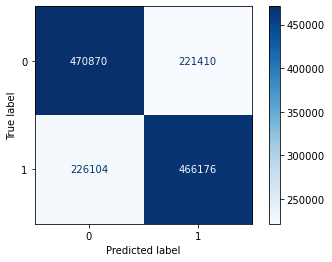

In [24]:
classification_metrics(y_train_smo, y_train_pred)

In [25]:
# Predict on test set
y_test_pred = model_log.predict(X_test_processed)
y_test_proba = model_log.predict_proba(X_test_processed)[:, 1]

In [26]:
# Probability of fraud for each application instance
y_test_proba

array([0.45160952, 0.23287196, 0.30856183, ..., 0.15124418, 0.36893089,
       0.73811538])

Precision: 
- Proportion of applications the model flagged as fradulent which are actually fradulent
- The ratio of True Positive to all the positives predicted by the model

Recall:
- Proportion of all truly fraudulent application which were flagged as fraudulent by our model
- The ratio of True Positives to all the positives in the dataset

In [27]:
#Functions to evaluate threshold based & threshold free metrics

def get_class_from_fraud_probability(fraud_probabilities, threshold=0.5):
    
    predicted_classes = [0 if fraud_probability<threshold else 1 
                         for fraud_probability in fraud_probabilities]

    return predicted_classes


def threshold_based_metrics(fraud_probabilities, true_label, thresholds_list):
    
    results = []
    
    for threshold in thresholds_list:
    
        predicted_classes = get_class_from_fraud_probability(fraud_probabilities, threshold=threshold)
    
        (TN, FP, FN, TP) = confusion_matrix(true_label, predicted_classes).ravel()
    
        MME = (FP+FN)/(TN+FP+FN+TP)
    
        TPR = TP/(TP+FN)
        TNR = TN/(TN+FP)
    
        FPR = FP/(TN+FP)
        FNR = FN/(TP+FN)
        
        BER = 1/2*(FPR+FNR)
        
        Gmean = np.sqrt(TPR*TNR)
    
        precision = 0
        FDR = 0
        F1_score=0
        
        if TP+FP>0:
            precision = TP/(TP+FP)
            FDR=FP/(TP+FP)
        
        NPV = 0
        FOR = 0
        
        if TN+FN>0:
            NPV = TN/(TN+FN)
            FOR = FN/(TN+FN)
            
        
        if precision+TPR>0:
            F1_score = 2*(precision*TPR)/(precision+TPR)
    
        results.append([threshold, MME, TPR, TNR, FPR, FNR, BER, Gmean, precision, NPV, FDR, FOR, F1_score])
        
    results_df = pd.DataFrame(results,columns=['Threshold' ,'MME', 'TPR', 'TNR', 'FPR', 'FNR', 'BER', 'G-mean', 'Precision', 'NPV', 'FDR', 'FOR', 'F1 Score'])
    
    return results_df

def evaluate(y_pred, FIXED_FPR = 0.05):
    
    fprs, tprs, thresholds = roc_curve(y_test, y_pred)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fprs, tprs)
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()
    
    tpr = tprs[fprs<FIXED_FPR][-1]
    fpr = fprs[fprs<FIXED_FPR][-1]
    threshold = thresholds[fprs<FIXED_FPR][-1]
        
    print("AUC:", roc_auc_score(y_test, y_pred))
    to_pct = lambda x: str(round(x, 4) * 100) + "%"
    print("TPR: ", to_pct(tpr), "\nFPR: ", to_pct(fpr), "\nThreshold: ", round(threshold, 2))

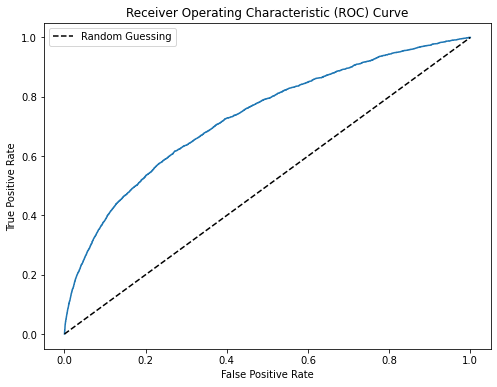

AUC: 0.7309096568962445
TPR:  25.840000000000003% 
FPR:  5.0% 
Threshold:  0.75


In [28]:
#AUC ROC Curve
evaluate(y_test_proba)

In [29]:
thresholds = [threshold/10 for threshold in range(0, 10)]
# results_df = threshold_based_metrics(y_test_proba, y_test, thresholds)
# results_df
performance_metrics=threshold_based_metrics(y_test_proba, y_test, thresholds)
performance_metrics[['Threshold','Precision','TPR']]

,Threshold,Precision,TPR
0,0.0,0.011030,1.000000
1,0.1,0.011151,0.997280
2,0.2,0.012316,0.960713
3,0.3,0.014402,0.888184
4,0.4,0.017652,0.788758
5,0.5,0.022308,0.655787
6,0.6,0.030288,0.503173
7,0.7,0.045058,0.344817
8,0.8,0.075839,0.154427
9,0.9,0.182390,0.008764


In [30]:
# Average Precision

def compute_AP(precision, recall):
    
    AP = 0
    
    n_thresholds = len(precision)
    
    for i in range(1, n_thresholds):
        
        if recall[i]-recall[i-1]>=0:
            
            AP = AP+(recall[i]-recall[i-1])*precision[i]
        
    return AP

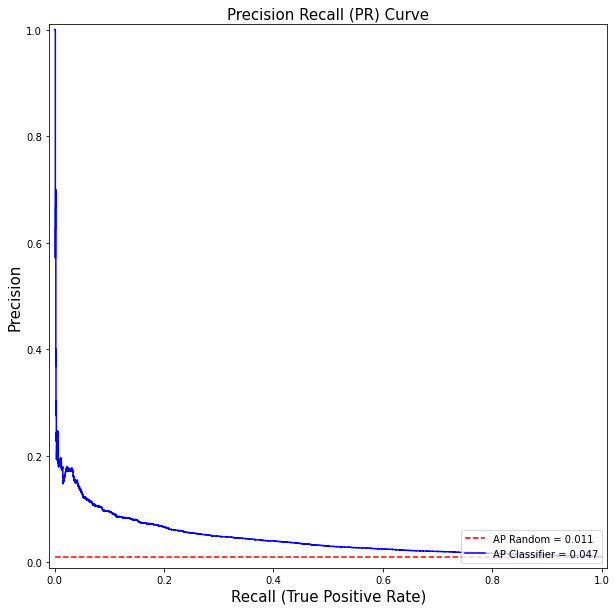

In [31]:
def get_template_pr_curve(ax, title,fs, baseline=0.5):
    ax.set_title(title, fontsize=fs)
    ax.set_xlim([-0.01, 1.01])
    ax.set_ylim([-0.01, 1.01])
    
    ax.set_xlabel('Recall (True Positive Rate)', fontsize=fs)
    ax.set_ylabel('Precision', fontsize=fs)
    
    ax.plot([0, 1], [baseline, baseline],'r--',label='AP Random = {0:0.3f}'.format(baseline))


    
precision, recall, threshold = precision_recall_curve(y_test, y_test_proba)
precision=precision[::-1]
recall=recall[::-1]
    
pr_curve, ax = plt.subplots(figsize=(10,10))
get_template_pr_curve(ax, "Precision Recall (PR) Curve",fs=15,baseline=sum(y_test)/len(y_test))
AP2 = average_precision_score(y_test, y_test_proba)
AP = compute_AP(precision, recall)
ax.step(recall, precision, 'b', color='blue', label = 'AP Classifier = {0:0.3f}'.format(AP))
ax.legend(loc = 'lower right')

In [32]:
classifier = DecisionTreeClassifier(max_depth = 10, random_state=10)
classifier.fit(X_train_processed, y_train_smo)

DecisionTreeClassifier(max_depth=10, random_state=10)

In [33]:
# Predict on test set
y_test_pred = classifier.predict(X_test_processed)
y_test_proba = classifier.predict_proba(X_test_processed)[:, 1]

In [34]:
thresholds = [threshold/10 for threshold in range(0, 10)]
performance_metrics=threshold_based_metrics(y_test_proba, y_test, thresholds)
performance_metrics[['Threshold','Precision','TPR']]

,Threshold,Precision,TPR
0,0.0,0.011030,1.000000
1,0.1,0.014349,0.805379
2,0.2,0.014267,0.745542
3,0.3,0.014282,0.730432
4,0.4,0.028135,0.411907
5,0.5,0.028190,0.399819
6,0.6,0.040251,0.259595
7,0.7,0.045289,0.195225
8,0.8,0.087284,0.105168
9,0.9,0.118455,0.054699


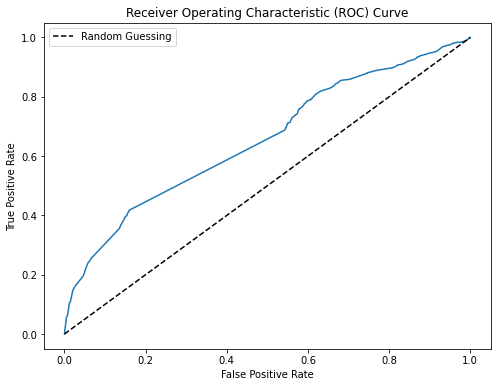

AUC: 0.655838420290155
TPR:  21.029999999999998% 
FPR:  4.97% 
Threshold:  0.68


In [35]:
evaluate(y_test_proba)

# XGBoost

In [36]:
xgb_classifier = xgb.XGBClassifier(random_state = 42)

xgb_classifier.fit(X_train_processed, y_train_smo)

y_train_pred = classifier.predict(X_train_processed)
y_test_pred = classifier.predict(X_test_processed)
y_test_proba = classifier.predict_proba(X_test_processed)[:, 1]

Accuracy: 0.78
Precision: 0.72
Recall: 0.82
F1 Score: 0.77
Confusion Matrix:


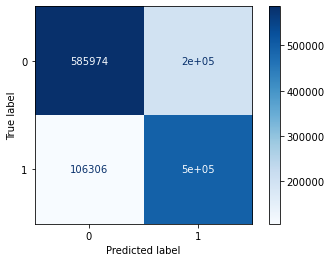

In [37]:
classification_metrics(y_train_pred, y_train_smo)

In [38]:
thresholds = [threshold/10 for threshold in range(0, 10)]
performance_metrics=threshold_based_metrics(y_test_proba, y_test, thresholds)
performance_metrics[['Threshold','Precision','TPR']]

,Threshold,Precision,TPR
0,0.0,0.011030,1.000000
1,0.1,0.014349,0.805379
2,0.2,0.014267,0.745542
3,0.3,0.014282,0.730432
4,0.4,0.028135,0.411907
5,0.5,0.028190,0.399819
6,0.6,0.040251,0.259595
7,0.7,0.045289,0.195225
8,0.8,0.087284,0.105168
9,0.9,0.118455,0.054699


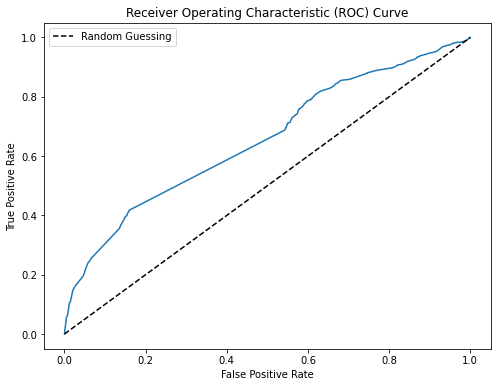

AUC: 0.655838420290155
TPR:  21.029999999999998% 
FPR:  4.97% 
Threshold:  0.68


In [39]:
evaluate(y_test_proba)

# EDA (Data Understanding):

# Data Processing

- Nulls
- Apply filters to realize our assumptions
- Standardize variables
- SMOTE to balance target
- Train/Test split


# Features

Types:
- Account related features: account number, card exp date, etc.
- Transaction related features: POS number, transaction time, amount, etc.
- Customer related features: customer number, type of customer, etc.

Feature transformation:
- Date/time variables: weekday or weekend
- Customer spending: average spending amount  + number of transactions
- Risk score: average number of fraud over a certain window 

# Baseline Model

- Logistic Regression 
    - Coefficients, statisitcal importance, explainability
- Decision Tree
    - Classification criteria, feature importance

# Evaluation

- Metrics: ROC (AUC Score), Recall, Confusion Matrix

# Hyperparameter Tuning --> Optimal Model

- Ensemble Methods:
    - Random Forest
    - Boosting

# Conclusion